In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pickle
import aptwrapper
import seaborn as sns
import utils
import pandas as pd

In [2]:
spectra_processed = pickle.load(open('./cache/spectra_vodd_processed.pkl', 'rb'))
maps_processed_aligned = pickle.load(open('./cache/maps_aligned_processed.pkl', 'rb'))
maps_raw = pickle.load(open('./cache/maps_raw.pkl', 'rb'))

In [3]:
crest = sns.color_palette('crest', 5)
flare = sns.color_palette('flare', 5)

# colormap = {
#     'control': flare[0],
#     'H₂O₂':   flare[1],
#     'NiCl₂':  flare[2],
#     'CoCl₂':  flare[3],
#     'heat':   crest[0],
#     'p53':    crest[1],
#     'p2':     crest[2],
#     'p33':    crest[3],
# }

colormap = {
    'control': sns.color_palette()[0],
    'B':      sns.color_palette()[0],
    'H₂O₂':   sns.color_palette()[2],
    'P':      sns.color_palette()[2],
    'NiCl₂':  sns.color_palette()[9],
    'CoCl₂':  sns.color_palette()[4],
    'heat':   sns.color_palette()[1],
    'H':      sns.color_palette()[1],
    'p53':    sns.color_palette()[3],
    'p2':     sns.color_palette()[5],
    'p33':    sns.color_palette()[7],
}

colormap['control']

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

# Images

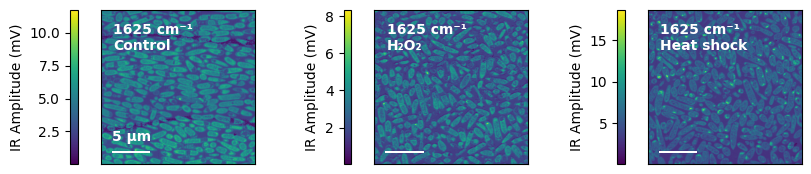

In [4]:
def plot_images(ax=None):
    if ax is None: fig, ax = plt.subplots(1, 3, figsize=(10, 2))
    def plot(dataset_id, annot, ax, cb_label='IR Amplitude (mV)', **kwargs):
        aptwrapper.plot_map(
            maps_raw[dataset_id].amp1625,
            ax=ax,
            cmap='viridis', cb_label=cb_label,
            annotation='1625 cm⁻¹\n' + annot, flatten=False, **kwargs)
        
    plot(
        'chemical_stress_validation_B_A', 'Control', ax[0]
    )
    plot(
        'chemical_stress_validation_P_A', 'H₂O₂', ax[1],
        show_sb_val=False
    )
    plot(
        'chemical_stress_validation_H_A', 'Heat shock', ax[2],
        show_sb_val=False
    )

plot_images()

# Spectra

In [5]:
def annotate_peak(ax, x, y, text=None, offset=-40, ha='center', va=None):
    if text is None: text=x
    if va is None and offset>0: va='baseline'
    if va is None and offset<0: va='top'
    # y = ymax if offset > 0 else ymin
    ax.annotate(
        text,
        [x,y],
        [x,
        y+offset],
        textcoords='data',
        rotation='vertical',
        va=va,
        ha=ha,
        arrowprops=dict(arrowstyle='-'),
        # fontsize=8
    )

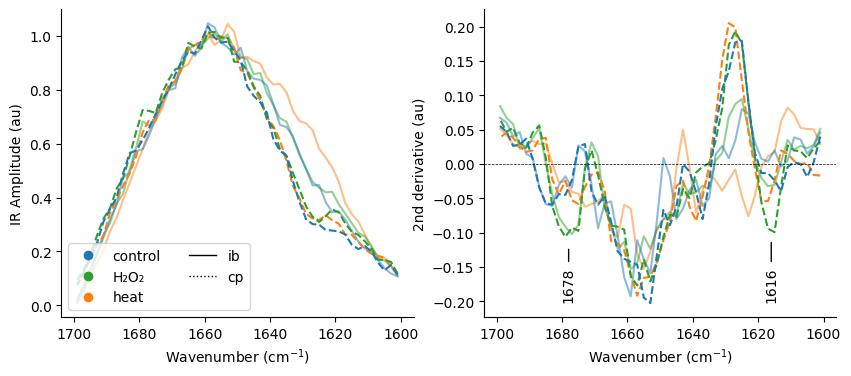

In [6]:
def plot_2diff_validation(derivative, ax=None, legend=True):
    if ax is None: ax = plt.gca()

    for i, f in enumerate(['ib', 'cp']):
        for j, c in enumerate('HPB'):
            s2 = (
                spectra_processed['IR Amplitude (mV)']
                .sel(si=(spectra_processed.feature==f) & (spectra_processed.condition==c))
                .groupby('dataset_id').mean('si')
            )

            if derivative:
                s2 = aptwrapper.savgol(s2,10,2,2)
                s2 = s2 / np.abs(s2.sel(v=slice(1600,1700)).sum('v'))

            s2 = s2.sel(v=slice(1600, 1700))
            m = s2.mean('dataset_id')
            se = s2.std('dataset_id') / np.sqrt(s2.count('dataset_id')) * 1.96

            ax.plot(
                s2.v, m, 
                label=f'{c}({f})',
                ls = '-' if f=='ib' else '--',
                c = colormap[c],
                alpha = .5 if f=='ib' else 1,
                # capsize=2
                )
        
            # for s in s2:
            #     ax.plot(s.v, s, c=f'C{i}', lw=.5, alpha=.2)

    if legend:
        ax.legend(loc='lower left', handles=[
            Line2D([0], [0], color=colormap['control'], lw=0, marker='o', label='control'),
            Line2D([0], [0], color=colormap['H₂O₂'], lw=0, marker='o', label='H₂O₂'),
            Line2D([0], [0], color=colormap['heat'], lw=0, marker='o', label='heat'),
            Line2D([0], [0], color='k', lw=1, ls='-', label='ib'),
            Line2D([0], [0], color='k', lw=1, ls=':', label='cp'),
        ], ncols=2)
    if derivative: 
        ax.axhline(0, c='k', lw=.5, ls='--')
        ax.set_ylabel('2nd derivative (au)')
    else:
        ax.set_ylabel('IR Amplitude (au)')
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    x1, x2 = ax.get_xlim()
    if x1 < x2: ax.invert_xaxis()

    if not derivative:
        y1, y2 = ax.get_ylim()
        dy = .01 * (y2 - y1)
        # ax.plot([1624,1624,1632,1632], [.85-dy,.85,.85,.85-dy], c='k')
        # ax.text(1628, .85+dy, 'p=.003', ha='center', va='bottom')
        # ax.plot([1676,1676,1680,1680], [.85-dy,.85,.85,.85-dy], c='k')
        # ax.text(1678, .85+dy, 'p=.04', ha='center', va='bottom')
    else:
        annotate_peak(ax, 1678, -.12, offset=-.05+.02)
        # annotate_peak(ax, 1638, -.09, offset=-.08+.02)
        # annotate_peak(ax, 1628, -.05, offset=-.12+.02)
        annotate_peak(ax, 1616, -.11, offset=-.06+.02)

    sns.despine(ax=ax)

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_2diff_validation(derivative=False, ax=ax[0])
plot_2diff_validation(derivative=True, ax=ax[1], legend=False)
# ax[0].axvline(1616)

## Beta content

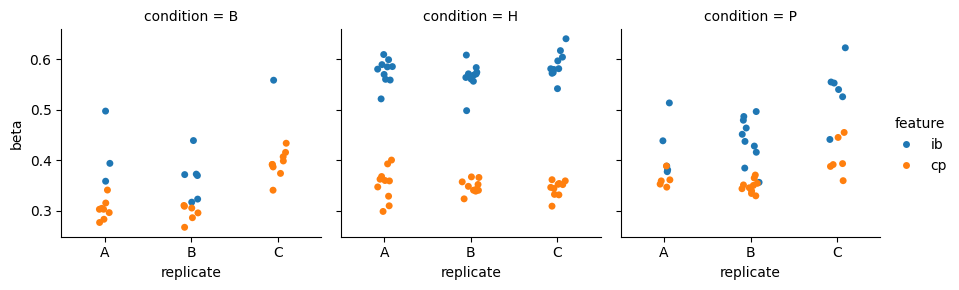

In [7]:
spectrum_quantification = pickle.load(open('./cache/spectrum_quantification.pkl', 'rb')).query(
    'experiment == "chemical_stress_validation" and feature != "bg"'
)

sns.catplot(
    spectrum_quantification, col='condition', x='replicate', y='beta',
    hue='feature',
    height=3
)

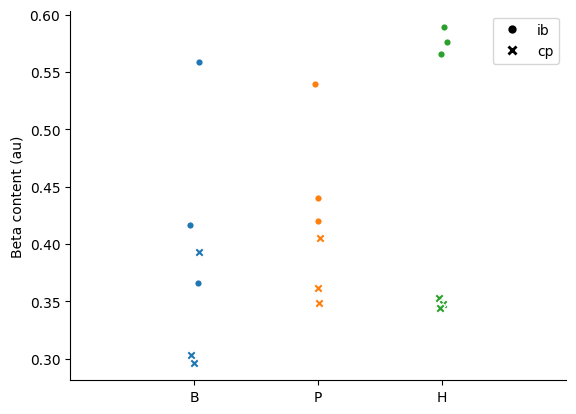

In [8]:
sq_ = spectrum_quantification.groupby(['feature', 'condition', 'replicate']).mean(numeric_only=True).reset_index()

for i, r in sq_.iterrows():
    x = list('BPH').index(r.condition)
    marker='o' if r.feature=='ib' else 'X'
    size = 30 if r.feature=='ib' else 50
    plt.scatter(x + np.random.randn()*.02, r.beta, c=f'C{x}', marker=marker, s=size, ec='w')

plt.xlim(-1,3)
plt.xticks([0,1,2], list('BPH'))
plt.ylabel('Beta content (au)')
plt.legend(handles=[
    Line2D([0], [0], color='k', markersize=7, markeredgecolor='w', lw=0, marker='o', label='ib'),
    Line2D([0], [0], color='k', markersize=8, markeredgecolor='w', lw=0, marker='X', label='cp'),
])
sns.despine()

## Quantification

In [9]:
import xarray as xr

s = spectra_processed['IR Amplitude (mV)']
s2 = aptwrapper.savgol(s,10,2,2)

sq2 = xr.Dataset({
    'peak_1616':    s.sel(v=slice(1614,1618)).mean('v'),
    'peak_1616_d2': s2.sel(v=slice(1614,1618)).mean('v'),
    'peak_1628':    s.sel(v=slice(1624,1632)).mean('v'),
    'peak_1628_d2':    s2.sel(v=slice(1624,1632)).mean('v'),
    'peak_1678':    s.sel(v=slice(1676,1680)).mean('v'),
    'peak_1678_d2': s2.sel(v=slice(1675,1682)).mean('v'),
}).to_dataframe().query('feature != "bg"').assign(fc=lambda x: x.feature+x.condition)

In [10]:
from scipy.stats import bootstrap

def split_plot(
        df, ax, x_major, x_minor, y, hue=None, major_order=None, 
        minor_order=None, hue_order=None, alpha=.5, kind='scatter',
        palette=None
):
    if palette is None: palette = [f'C{i}' for i in range(10)]
    all_xs = []

    x_major_values = major_order or df[x_major].unique()
    if hue in df and hue_order is None: 
        hue_order = list(df[hue].unique())

    for i in range(len(x_major_values)):
        df1 = df[df[x_major] == x_major_values[i]]

        x_minor_values = minor_order or df1[x_minor].unique()
        num_minor = len(x_minor_values)
    
        for j in range(num_minor):
            df2 = df1[df1[x_minor] == x_minor_values[j]]
            x = 1 + i + (j - num_minor/2 + .5) / num_minor * .5
            all_xs.append(x)

            if hue in df:
                c = [palette[hue_order.index(f)] for f in df2[hue]]
            else:
                c = np.repeat([hue or 'C0'], len(df2))

            for color, df3 in df2.groupby(c):

                if kind == 'scatter' or kind == 'both':
                    ax.scatter(
                        np.repeat(x, len(df3)), 
                        df3[y],
                        c=color, ec='w', alpha=alpha
                    )

                if (kind == 'error' or kind == 'both') and len(df3) > 0:
                    if len(df3[y]) < 2: continue
                    m = df3[y].mean()
                    ci = bootstrap((df3[y].dropna().to_numpy(),), np.mean, confidence_level=0.95).confidence_interval
                    # for xi, mi, ci_i, c_i in np.broadcast(x, m, ci, c):
                    #     ax.errorbar(xi, mi, ([mi-ci_i.low], [ci_i.high-mi]), c=color_i, capsize=2, marker='.')
                    
                    ax.errorbar(x, m, ([m-ci.low], [ci.high-m]), c=color, capsize=2, marker='.')

    return all_xs

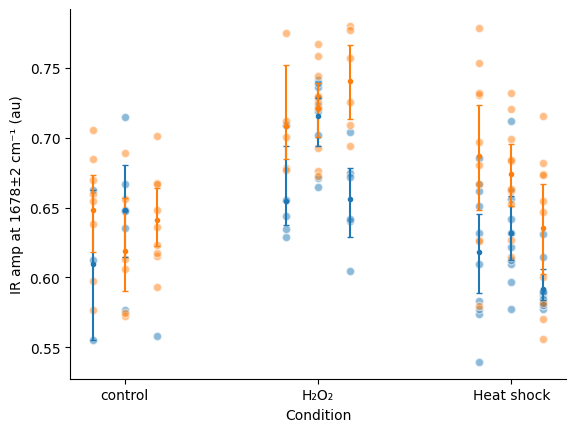

In [11]:
def plot_1678_quantification(ax=None):
    if ax is None: ax = plt.gca()

    split_plot(
        sq2,
        ax=ax,
        x_major='condition',
        x_minor='replicate',
        y='peak_1678',
        hue='feature',
        major_order=['B', 'P', 'H'],
        hue_order=['ib', 'cp'],
        kind='both',
    )

    ax.set_ylabel('IR amp at 1678±2 cm⁻¹ (au)')
    ax.set_xlabel('Condition')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['control', 'H₂O₂', 'Heat shock'])
    sns.despine(ax=ax)

plot_1678_quantification()

In [12]:
import utils

def annot(ax, x0, x1, text, c='k'):
    """ Add significance-type annotations to a plot """

    y0, y1 = ax.get_ylim()
    dy = .01 * (y1 - y0)
    text_pad = dy
    y = y1 + .1 * (y1 - y0)

    pts = [[(x0, y-3*dy), (x0, y)]] + [
        [(x1i, y), (x1i, y-dy), (x1i, y)] for x1i in x1
    ]
    pts = np.array([p for x in pts for p in x])

    ax.plot(pts[:,0], pts[:,1], c=c)
    ax.text(np.mean([x0, *x1]), y+text_pad, text, ha='center', va='bottom', c=c)

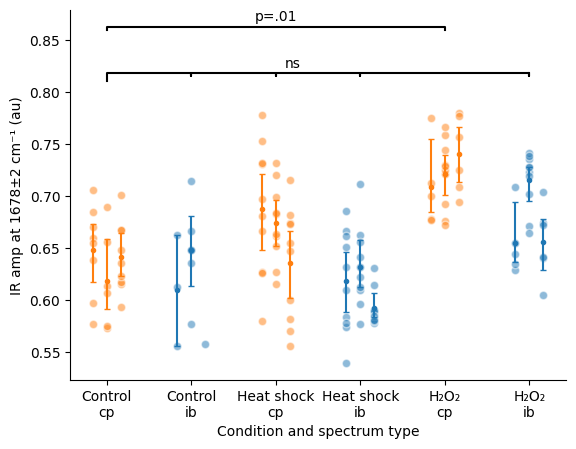

In [13]:
def plot_1678_quantification_dodged(ax=None):
    if ax is None: ax = plt.gca()

    df = sq2.assign(
        cf=lambda x: x.condition + '\n' + x.feature
    )
    
    names = ['Control\ncp', 'Control\nib', 'Heat shock\ncp', 'Heat shock\nib', 'H₂O₂\ncp', 'H₂O₂\nib']
    order = ['B\ncp', 'B\nib', 'H\ncp', 'H\nib', 'P\ncp', 'P\nib']

    split_plot(
        df,
        ax=ax,
        x_major='cf',
        x_minor='replicate',
        y='peak_1678',
        hue='cf',
        major_order=order,
        hue_order=order,
        palette=['C1', 'C0', 'C1', 'C0', 'C1', 'C0'],
        kind='both',
    )

    ax.set_xticks([1,2,3,4,5,6], names)
    ax.set_ylabel('IR amp at 1678±2 cm⁻¹ (au)')
    ax.set_xlabel('Condition and spectrum type')
    annot(ax, 1, [2, 3, 4, 6], 'ns', c='k')
    utils.annot(ax, 3,2, 'p=.01', c='k')
    sns.despine(ax=ax)
    

plot_1678_quantification_dodged()

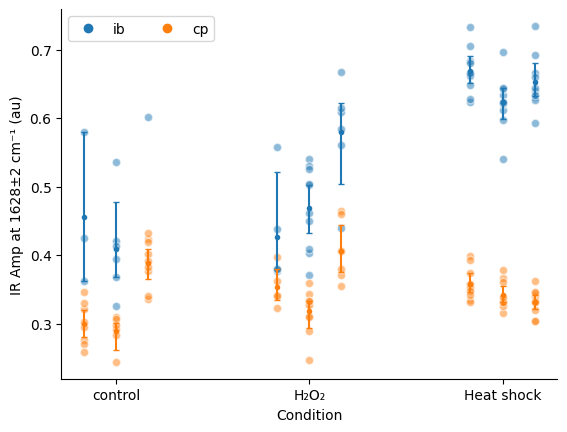

In [14]:
def plot_1628_quantification(ax=None):
    if ax is None: ax = plt.gca()

    split_plot(
        sq2,
        ax=ax,
        x_major='condition',
        x_minor='replicate',
        y='peak_1628',
        hue='feature',
        major_order=['B', 'P', 'H'],
        hue_order=['ib', 'cp'],
        kind='both',
    )

    ax.set_ylabel('IR Amp at 1628±2 cm⁻¹ (au)')
    ax.set_xlabel('Condition')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['control', 'H₂O₂', 'Heat shock'])
    ax.legend(loc='upper left', ncols=2, handles=
        [
            Line2D([0], [0], color='C0', lw=0, marker='o', label='ib'),
            Line2D([0], [0], color='C1', lw=0, marker='o', label='cp'),
        ]
    )
    sns.despine(ax=ax)

plot_1628_quantification()

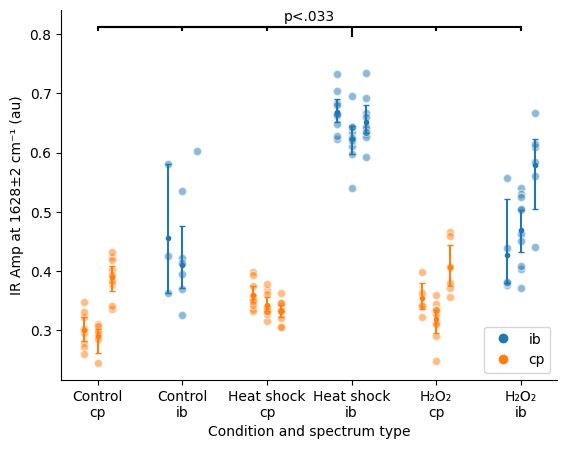

In [15]:
def plot_1628_quantification_dodged(ax=None):
    if ax is None: ax = plt.gca()

    df = sq2.assign(
        cf=lambda x: x.condition + '\n' + x.feature
    )
    
    names = ['Control\ncp', 'Control\nib', 'Heat shock\ncp', 'Heat shock\nib', 'H₂O₂\ncp', 'H₂O₂\nib']
    order = ['B\ncp', 'B\nib', 'H\ncp', 'H\nib', 'P\ncp', 'P\nib']

    split_plot(
        df,
        ax=ax,
        x_major='cf',
        x_minor='replicate',
        y='peak_1628',
        hue='cf',
        major_order=order,
        hue_order=order,
        palette=['C1', 'C0', 'C1', 'C0', 'C1', 'C0'],
        kind='both',
    )

    ax.set_ylabel('IR Amp at 1628±2 cm⁻¹ (au)')
    ax.set_xlabel('Condition and spectrum type')
    ax.set_xticks([1,2,3,4,5,6], names)
    ax.legend(ncols=1, loc='lower right', handles=
        [
            Line2D([0], [0], color='C0', lw=0, marker='o', label='ib'),
            Line2D([0], [0], color='C1', lw=0, marker='o', label='cp'),
        ]
    )
    sns.despine(ax=ax)
    annot(ax, 4, [1, 2, 3, 5, 6], 'p<.033', c='k')
    # utils.annot(ax, 3,2, 'p=.01', c='k')


plot_1628_quantification_dodged()

## Statistics

Beta: ANOVA differences between spectra

The ibH spectra are different from all others

In [16]:
import scipy.stats

def dunnett(data, outcome, groupby, control, mean_over=None, alpha=.05):
    def tolist (x):
        return x if isinstance(x, list) else [x]
    
    if mean_over is not None:
        data = (
            data.groupby(tolist(groupby) + tolist(mean_over))
            .mean(numeric_only=True)
            .reset_index()
        )

    groups = {
        gname: gdata[outcome].dropna().values
        for gname, gdata in data.groupby(groupby)
    }

    control_data = groups[control]
    del groups[control]

    d = scipy.stats.dunnett(
        *[groups[k] for k in groups],
        control=control_data,
    )

    return pd.DataFrame({
        'group': list(groups.keys()),
        'reject_H0': d.pvalue < alpha,
        'p_dunnett': d.pvalue,
        'statistic': d.statistic,
        'n_group': [len(g) for g in groups.values()],
        'alpha': alpha,
    }).set_index('group')

In [17]:
dunnett(sq2, 'peak_1628', 'fc', 'ibH', mean_over='replicate')

,reject_H0,p_dunnett,statistic,n_group,alpha
group,,,,,
cpB,True,0.000133,-6.515747,3,0.05
cpH,True,0.000176,-6.155171,3,0.05
cpP,True,0.000356,-5.849360,3,0.05
ibB,True,0.028547,-3.221040,3,0.05
ibP,True,0.031437,-3.164394,3,0.05


1678: there are differences

In [18]:
utils.test_mean_differences(
    sq2,#.query('feature=="cp"'),
    outcome='peak_1678',
    groupby=['feature', 'condition'],
    mean_over=['replicate'],
    alpha=.025
)

reject_H0                                                      True
using_anova                                                    True
p_anova                                                    0.020586
p_kruskal                                                  0.159392
p_shapiro                [3.662, 3.853, 6.377, 6.659, 5.369, 0.362]
p_bartlett                                                 5.485738
n_per_group                                      [3, 3, 3, 3, 3, 3]
bonferroni_multiplier                                             8
dtype: object

cpP is stat different from everything, except cpH and ibP

In [19]:
dunnett(sq2, 'peak_1678', 'fc', 'cpB', mean_over='replicate')

,reject_H0,p_dunnett,statistic,n_group,alpha
group,,,,,
cpH,False,0.605137,1.263721,3,0.05
cpP,True,0.010969,3.753585,3,0.05
ibB,False,0.571175,-1.316326,3,0.05
ibH,False,0.806705,-0.946467,3,0.05
ibP,False,0.359101,1.683892,3,0.05


# IB number

In [20]:
celltable = pickle.load(open('./cache/celltable.pkl', 'rb'))
celltable = celltable.query('experiment == "chemical_stress_validation"')
ibtable = pickle.load(open('./cache/ibtable.pkl', 'rb'))
ibtable = ibtable.query('experiment == "chemical_stress_validation"')
ibt_ = ibtable.groupby(['dataset_id', 'condition', 'replicate']).mean(numeric_only=True).reset_index()
ct_ = celltable.groupby(['dataset_id', 'condition', 'replicate']).mean(numeric_only=True).reset_index()

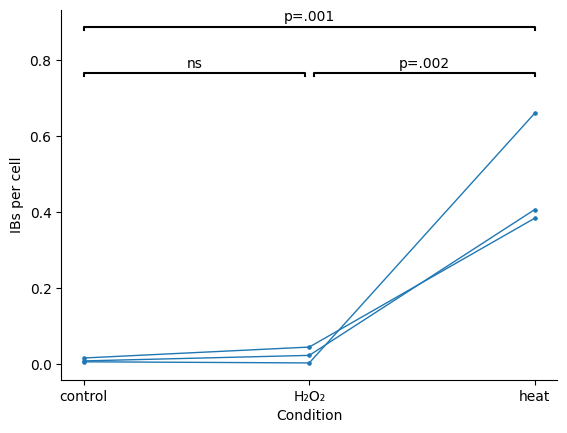

In [21]:
def plot_num_ibs(ax=None):
    if ax is None: fig, ax = plt.subplots()
    sns.pointplot(
        ct_, ax=ax,
        x='condition', y='cell_num_ibs', hue='replicate', legend=False,
        lw=1, order='BPH', palette=['C0', 'C0', 'C0']
    )
    ax.set(xlabel='Condition', ylabel='IBs per cell', xticks=[0,1,2], xticklabels=['control', 'H₂O₂', 'heat'])
    sns.despine(ax=ax)
    utils.annot(ax, [.49, 1.51], .49, ['ns', 'p=.002'])
    utils.annot(ax, 1, 1, 'p=.001')

plot_num_ibs()

In [22]:
utils.test_mean_differences(
    celltable,#.assign(cell_num_ibs=lambda x: np.log(x.cell_num_ibs)),
    outcome='cell_num_ibs',
    groupby='condition',
    mean_over='replicate',
    alpha=.01
)

reject_H0                                 True
using_anova                               True
p_anova                               0.004871
p_kruskal                              0.30405
p_shapiro                [2.136, 0.709, 4.731]
p_bartlett                             0.01079
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

In [23]:
def tukey_hsd(data, outcome, groupby, mean_over):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    from statsmodels.stats.multicomp import MultiComparison
    
    data = data.groupby([groupby, mean_over])[outcome].mean().reset_index()
    mc = MultiComparison(data[outcome], data[groupby])
    result = mc.tukeyhsd()
    return result

tukey_hsd(
    celltable,#.assign(cell_num_ibs=lambda x: np.log(x.cell_num_ibs)),
    outcome='cell_num_ibs',
    groupby='condition',
    mean_over='replicate'
).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
B,H,0.4741,0.0016,0.2498,0.6985,True
B,P,0.0135,0.9815,-0.2109,0.2378,False
H,P,-0.4607,0.0018,-0.685,-0.2363,True


## Kolmogorov-Smirnov test

(array([0.68308566, 0.04978615]),
 <xarray.DataArray 'v' (s: 2)>
 array([1662.66266266, 1614.91491491])
 Coordinates: (12/26)
     Label               <U30 'Spectrum 2'
     Location.X          float64 -176.5
     Location.Y          float64 -768.9
     PulseRate           float64 779.6
     TimeStamp           datetime64[ns] 2024-01-03T20:17:05.343931
     AFMMode             <U7 'Contact'
     ...                  ...
     date                object 2024-01-03
     sample_id           <U30 'chemical_stress_validation_B_A'
     dataset_id          <U40 'chemical_stress_validation_B_A'
     time_post_shock     float64 nan
     feature             <U2 'ib'
     bg_filename         <U33 'bg02.irb'
 Dimensions without coordinates: s)

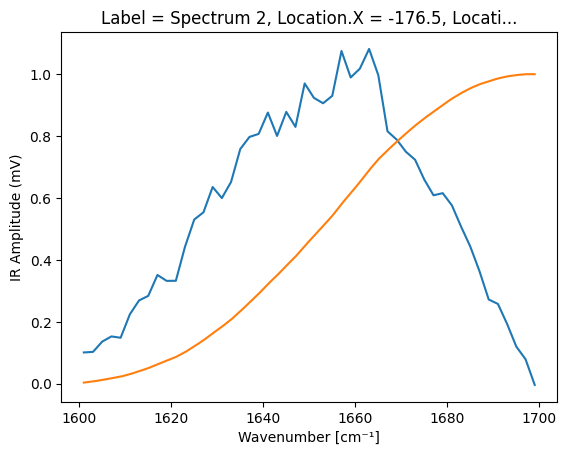

In [24]:
s_pdf = spectra_processed.isel(si=0)['IR Amplitude (mV)'].sel(v=slice(1600,1700))
s_pdf.plot()
s_cdf = s_pdf.cumsum('v')
s_cdf = s_cdf / s_cdf.max('v')
s_cdf = s_cdf.interp(v=np.linspace(1600,1700,1000))
s_cdf.plot()
x = xr.DataArray(np.random.random_sample(2), dims=['s'])
# x = 0.9170814
# i = np.abs(s_cdf - x).argmin('v')
# s_cdf.v.isel(v=805)
x.values, np.abs(s_cdf - x).idxmin('v')

In [25]:
def draw_from_spectrum(spectrum):
    s_pdf = spectrum['IR Amplitude (mV)'].sel(v=slice(1600,1700))
    s_cdf = s_pdf.cumsum('v')
    s_cdf = s_cdf / s_cdf.max('v')
    s_cdf = s_cdf.interp(v=np.linspace(1600,1700,1000))

    def draw(size=10):

        x = xr.DataArray(np.random.random_sample(size), dims=['s'])
        v = np.abs(s_cdf - x).idxmin('v').values
        # print(v)
        return v
    
    return draw

s2 = (
    spectra_processed
    .assign_coords(group=lambda x: x.feature + x.condition)
    .groupby('group').mean('si')
)

# ksdf = pd.DataFrame(
#     [
#         [g1, g2, scipy.stats.ks_2samp(draw_from_spectrum(s2.sel(group=g1))(size=int(1e5)), draw_from_spectrum(s2.sel(group=g2))(size=int(1e2)))]
#         for g1 in ['cpP']#, 'ibH']
#         for g2 in s2.group.values
#         if 'bg' not in g1 and 'bg' not in g2
#     ],
#     columns=['g1', 'g2', 'ks']
# )

In [26]:
# ksdf.assign(
#     s      = lambda x: x.ks.map(lambda y: y.statistic),
#     p      = lambda x: x.ks.map(lambda y: y.pvalue),
#     p_adj  = lambda x: x.p * len(x),
#     reject = lambda x: x.p_adj < .05,
# ).drop(columns=['ks']).set_index(['g1', 'g2'])#.query('reject')

# Composite

In [27]:
celltable.groupby(['condition', 'replicate']).cell_num_ibs.sum().unstack().loc[['B', 'P', 'H']]

replicate,A,B,C
condition,,,
B,2,4,2
P,6,14,1
H,103,103,156


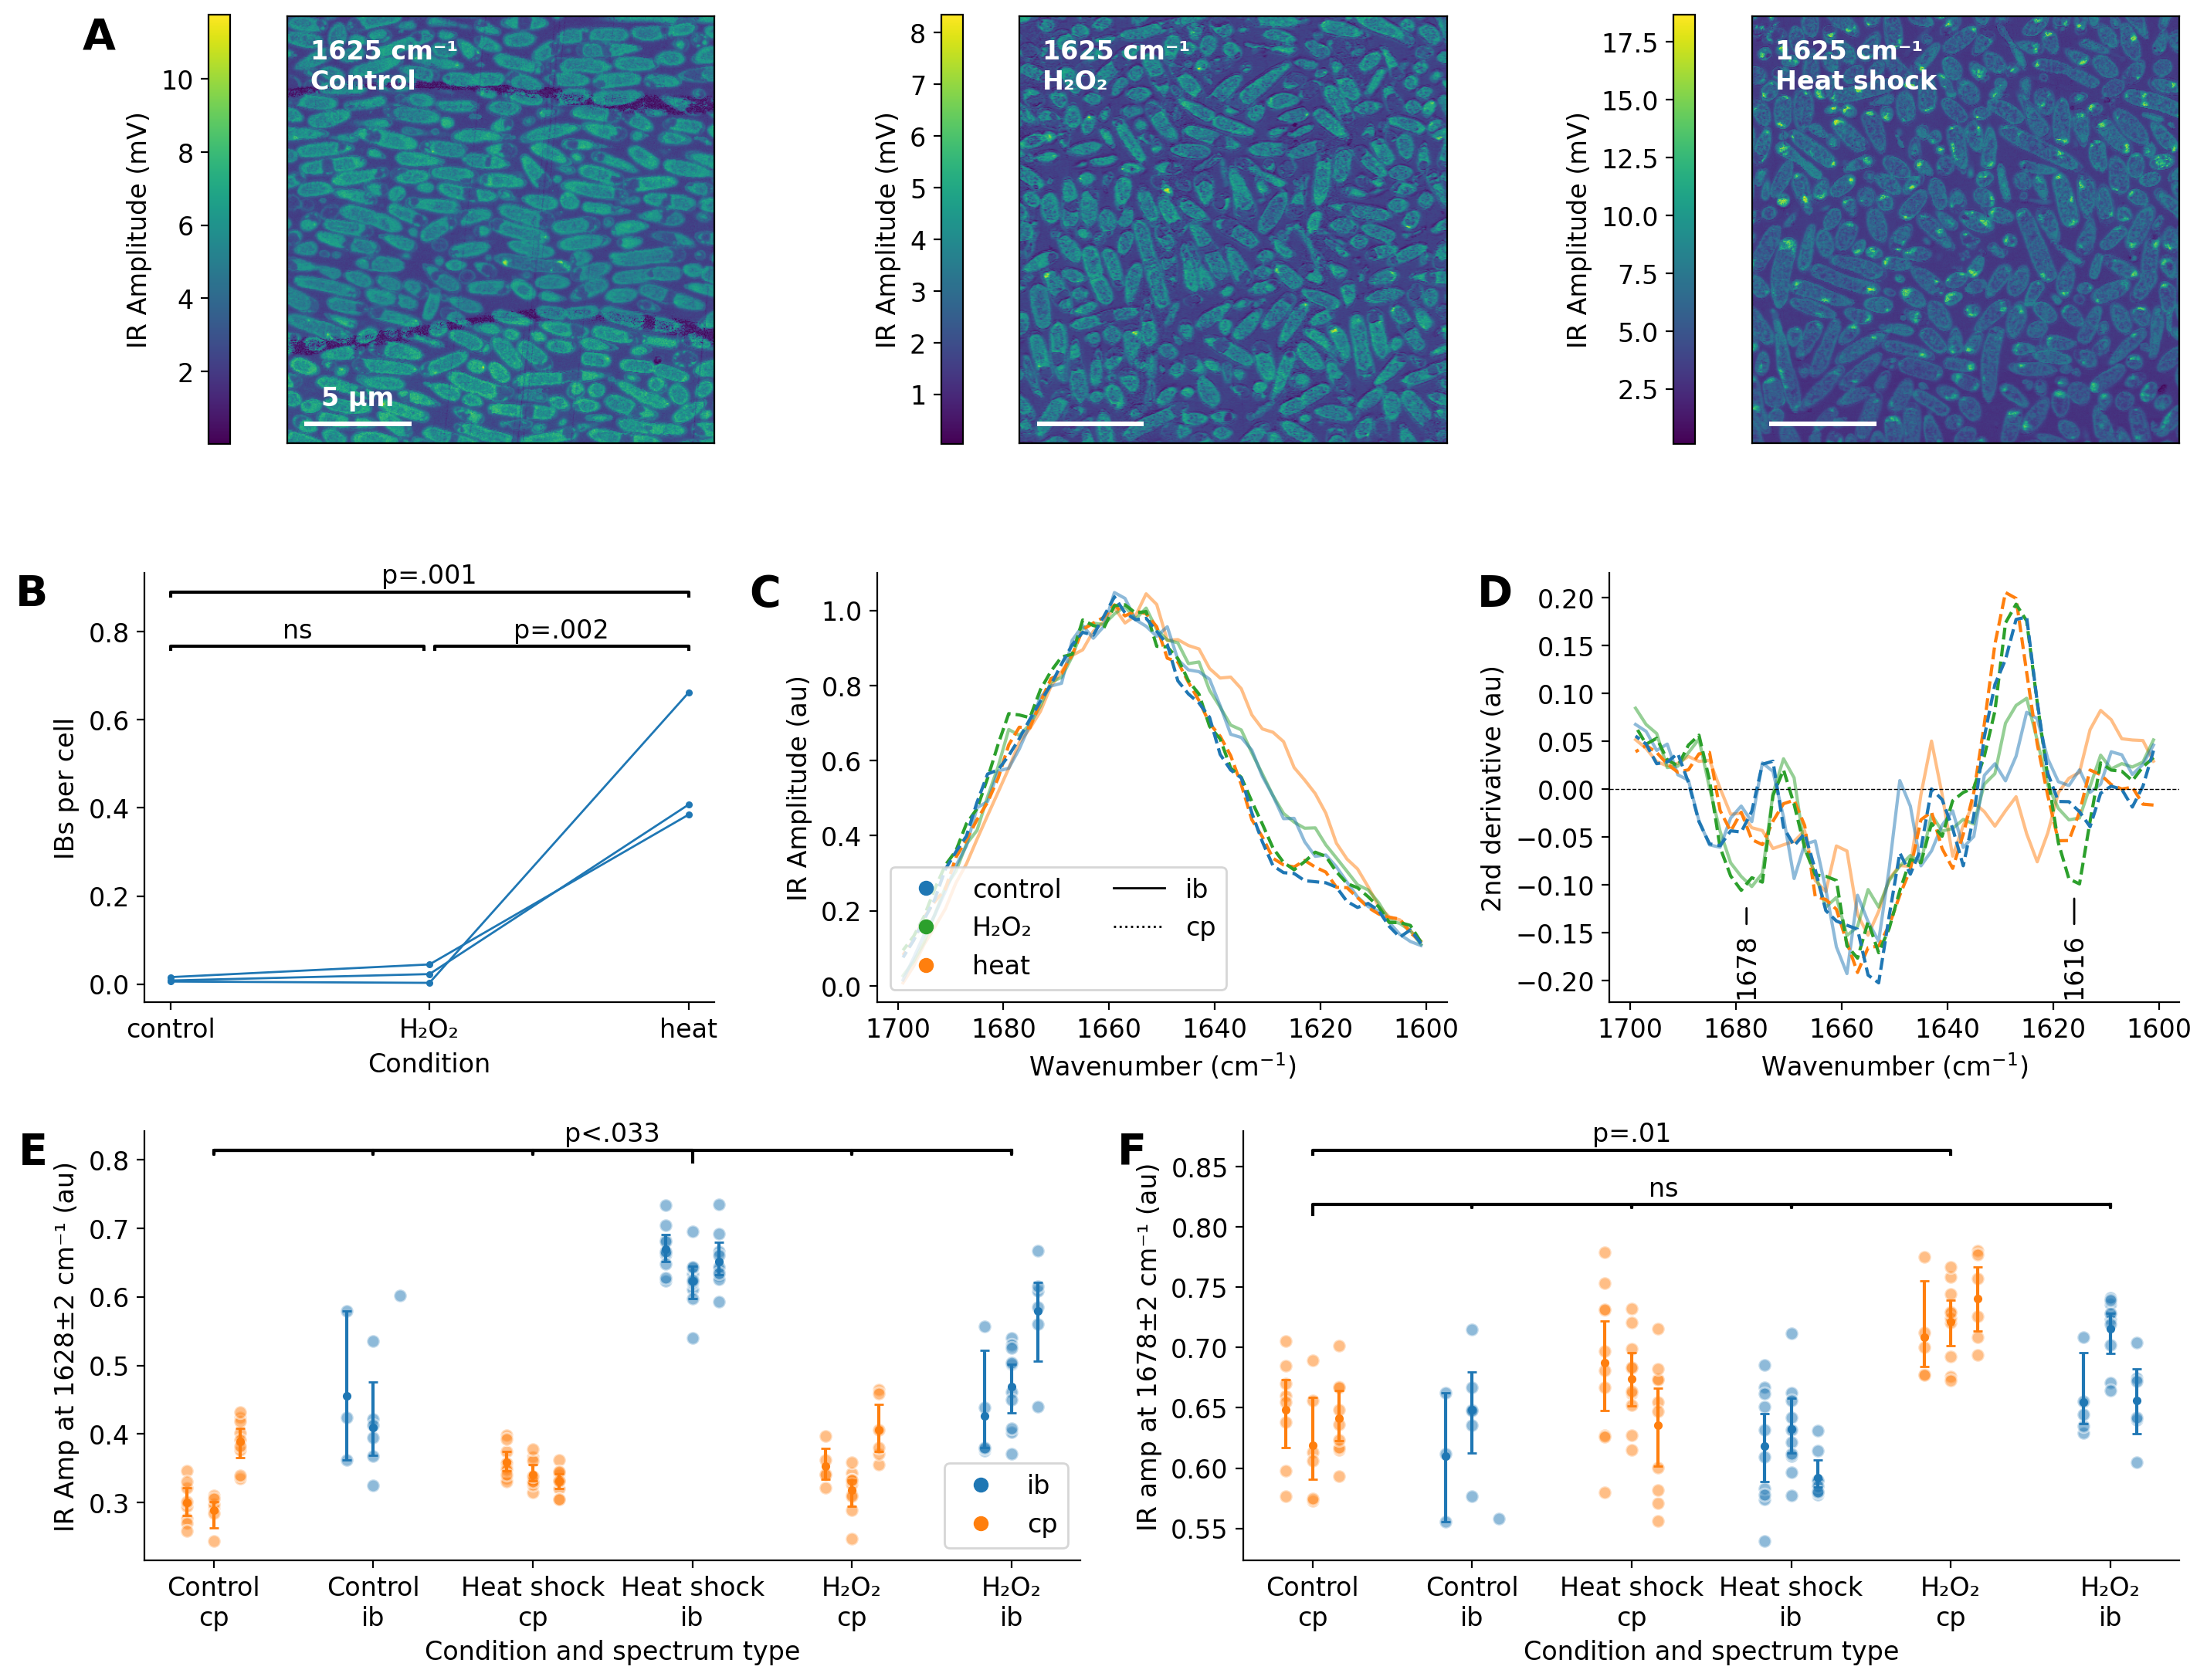

In [28]:
with plt.rc_context({
    'figure.figsize': (17,13),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    
    fig, ax = plt.subplot_mosaic(
        gridspec_kw={'height_ratios':[1,1,1], 'wspace': .8, 'hspace': .3},
        mosaic=[
            ['a', 'a', 'b', 'b', 'c', 'c'],
            ['f', 'f', 'd', 'd', 'e', 'e'],
            ['g', 'g', 'g', 'h', 'h', 'h'],
    ])
    # plt.tight_layout(h_pad=3, w_pad=4)

    plot_images(ax=[ax['a'], ax['b'], ax['c']])
    plot_2diff_validation(derivative=False, ax=ax['d'])
    plot_2diff_validation(derivative=True, ax=ax['e'], legend=False)
    plot_num_ibs(ax=ax['f'])
    plot_1628_quantification_dodged(ax=ax['g'])
    plot_1678_quantification_dodged(ax=ax['h'])
    # ax['i'].axis('off')

    kwargs = dict(
            ha='right',
            va='top',
            xycoords=('axes points', 'axes fraction'),
            fontsize=20,
            fontweight='bold'
    )

    ax['a'].annotate('A', (-80,1), **kwargs)
    ax['f'].annotate('B', (-45,1), **kwargs)
    ax['d'].annotate('C', (-45,1), **kwargs)
    ax['e'].annotate('D', (-45,1), **kwargs)
    ax['g'].annotate('E', (-45,1), **kwargs)
    ax['h'].annotate('F', (-45,1), **kwargs)

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.savefig('../figures/figure_4.pdf', bbox_inches='tight')
    